# Preparación para el TF MDS

## Preparación de los datos

Dataset: https://www.yelp.com/dataset/documentation/main

Crea un dataframe con 100 fotos de cada categoría (label), escaladas y recortadas a 100 x 100

**Requiere ejecución del notebook '00_EDA.ipynb'** para generar el archivo checkpoints/df3.pkl

In [1]:
import os
import pickle
import pandas as pd
from PIL import Image
from tqdm.notebook import trange, tqdm
import torchvision.transforms as T
import shutil
import math
import numpy as np
from keras.utils import np_utils

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2022-09-05 15:24:43.100994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-05 15:24:43.101140: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset_photos_path = 'dataset/photos'
dataset_output_path = 'dataset/toy_flat'
photo_size = 100 # 100 x 100 pixeles
df_pickle_file='checkpoints/df5.pkl'
max_photos=100 # numero de fotos de cada categoria

In [3]:
df = pickle.load(open('checkpoints/df3.pkl','rb'))

In [4]:
df.head()

,label,x_dim,y_dim,z_channels,pixels,corrupt
photo_id,,,,,,
--0h6FMC0V8aMtKQylojEg,inside,400.0,300.0,3.0,120000.0,False
--3JQ4MlO-jHT9xbo7liug,food,400.0,400.0,3.0,160000.0,False
--3P3fjPrScy06XVLi4vhg,inside,400.0,560.0,3.0,224000.0,False
--4DfhW2sJvjeC90KEDX3g,inside,400.0,300.0,3.0,120000.0,False
--5V3mRlhb3zqE5yF4Gpaw,inside,400.0,300.0,3.0,120000.0,False


In [5]:
# nos quedamos solo con los archivos válidos
df = df.loc[df.corrupt == False]

In [6]:
# nos quedamos con photo_id y label
df = df.drop(columns=['x_dim', 'y_dim', 'z_channels', 'pixels','corrupt']).reset_index()
df

,photo_id,label
0,--0h6FMC0V8aMtKQylojEg,inside
1,--3JQ4MlO-jHT9xbo7liug,food
2,--3P3fjPrScy06XVLi4vhg,inside
3,--4DfhW2sJvjeC90KEDX3g,inside
4,--5V3mRlhb3zqE5yF4Gpaw,inside
...,...,...
199993,zzvNHEgplGVXAzxDJ_I0dg,drink
199994,zzwVMQ3NIAHCmNe4hJa4qw,outside
199995,zzwXBLKbKiJnEPTqKTHAiw,food
199996,zzyP051L-ROFT9nMzMDPjQ,food


## Generar Train

In [7]:
## Seleccionar 80% x max_photos fotos de cada categoría
df_subset = pd.DataFrame([], columns=['photo_id',
                                'label'])
total_photos = df.label.value_counts()
for label in total_photos.index:
    if total_photos[label] > max_photos: # Hay muchas fotos. Preservar un subconjunto.
        df_subset = pd.concat([df_subset,
                            df.loc[df.label == label].sample(n=int(max_photos*0.8))])
    else: # Hay pocas fotos. Preservar todas.
        df_subset = pd.concat([df_subset,
                            df.loc[df.label == label]])
df_train = df_subset

## Generar Test

In [8]:
fotos_que_quedan = df[~df['photo_id'].isin(df_train['photo_id'])]

In [9]:
## Seleccionar 20% x max_photos de cada categoría
df_subset = pd.DataFrame([], columns=['photo_id',
                                'label'])
for label in total_photos.index:
    if total_photos[label] > max_photos: # Hay muchas fotos. Preservar un subconjunto.
        df_subset = pd.concat([df_subset,
                            fotos_que_quedan.loc[fotos_que_quedan.label == label].sample(n=int(max_photos*0.2))])
    else: # Hay pocas fotos. Preservar todas.
        df_subset = pd.concat([df_subset,
                            fotos_que_quedan.loc[fotos_que_quedan.label == label]])
df_test = df_subset

In [10]:
df_train.label.value_counts()

food       80
inside     80
outside    80
drink      80
menu       80
Name: label, dtype: int64

In [11]:
df_test.label.value_counts()

food       20
inside     20
outside    20
drink      20
menu       20
Name: label, dtype: int64

Confirmar que no hay fotos de df_test en df_train

In [44]:
df_train[df_train['photo_id'].isin(df_test['photo_id'])]

,photo_id,label


## Cargar fotos el el dataframe
Queremos:

`X.shape = (N, photo_size, photo_size, 3)
y.shape = (N, P)`

Donde:
- N es el número de imagenes (P x max_photos).
- P es el número de categorías (labels)

Las fotos se escalarán y recortarán a 224 x 224.

### Train

In [12]:
df2_train = df_train.copy()
df2_train['image']=""

In [13]:
df2_train.head()

,photo_id,label,image
165105,oph_MmD3MzCGTA2-LFn2ZA,food,
6084,0vwZDyv0D83AjR3ESCf53A,food,
128415,d2q50ccC-mqxb-muROfqOA,food,
166656,pKoEaI8K0ED_Z9VfEqCLfw,food,
8716,1kKPGF3lXeABuUU1tFnm-g,food,


In [14]:
example_photo = Image.open('{}/{}.jpg'.format(dataset_photos_path, df2_train.iloc[1].photo_id))

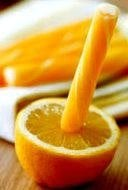

In [15]:
example_photo

In [16]:
example_photo.size

(128, 190)

In [17]:
# redimensionar, recortar y guardar fotos

for im_pos in tqdm(range(len(df_train)), desc='Photos cropped', miniters=len(df_train)//100):
    
    with Image.open('{}/{}.jpg'.format(dataset_photos_path, df_train.iloc[im_pos].photo_id)) as image:

        width = image.size[0]
        height = image.size[1]

        # redimensionar
        if (height < width): # imagen estrecha
            height = int(photo_size)
            height = math.floor(photo_size * width/height)
        else: # imagen ancha
            width = math.floor(photo_size * height/width)
            height = int(photo_size)

        resized = T.Resize((height, width))(image)
        cropped = T.CenterCrop(size=int(photo_size))(resized)
        
        df2_train.iloc[im_pos,2]=cropped

Photos cropped:   0%|          | 0/400 [00:00<?, ?it/s]

In [18]:
df2_train.head()

,photo_id,label,image
165105,oph_MmD3MzCGTA2-LFn2ZA,food,<PIL.Image.Image image mode=RGB size=100x100 a...
6084,0vwZDyv0D83AjR3ESCf53A,food,<PIL.Image.Image image mode=RGB size=100x100 a...
128415,d2q50ccC-mqxb-muROfqOA,food,<PIL.Image.Image image mode=RGB size=100x100 a...
166656,pKoEaI8K0ED_Z9VfEqCLfw,food,<PIL.Image.Image image mode=RGB size=100x100 a...
8716,1kKPGF3lXeABuUU1tFnm-g,food,<PIL.Image.Image image mode=RGB size=100x100 a...


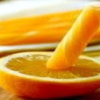

In [19]:
df2_train.iloc[1,2] # 2 = columna 'image'

### Test

In [20]:
df2_test = df_test.copy()
df2_test['image']=""

In [21]:
# redimensionar, recortar y guardar fotos

for im_pos in tqdm(range(len(df_test)), desc='Photos cropped', miniters=len(df_test)//100):
    
    with Image.open('{}/{}.jpg'.format(dataset_photos_path, df_test.iloc[im_pos].photo_id)) as image:

        width = image.size[0]
        height = image.size[1]

        # redimensionar
        if (height < width): # imagen estrecha
            height = int(photo_size)
            height = math.floor(photo_size * width/height)
        else: # imagen ancha
            width = math.floor(photo_size * height/width)
            height = int(photo_size)

        resized = T.Resize((height, width))(image)
        cropped = T.CenterCrop(size=int(photo_size))(resized)
        
        df2_test.iloc[im_pos,2]=cropped

Photos cropped:   0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
df2_test.head()

,photo_id,label,image
3637,0AK1Dud1GBqaIAPC9PS1HQ,food,<PIL.Image.Image image mode=RGB size=100x100 a...
136093,fXqYxRJP1RrNVDqvTWMEvg,food,<PIL.Image.Image image mode=RGB size=100x100 a...
47074,E2i4snhK1y2vu7AlbDqLYQ,food,<PIL.Image.Image image mode=RGB size=100x100 a...
179056,tEv4_2iC6HS3STpPxxGmeg,food,<PIL.Image.Image image mode=RGB size=100x100 a...
59023,HreXxc8QcTG_jTWX9CM4Hg,food,<PIL.Image.Image image mode=RGB size=100x100 a...


## Generar X

### X_train

In [23]:
series_X_train = df2_train.image.map(lambda img: np.array(img.getdata()).reshape(photo_size, photo_size, 3))

In [24]:
X_train = np.stack(series_X_train.to_numpy(copy=True))

In [25]:
X_train.shape

(400, 100, 100, 3)

### X_test

In [26]:
series_X_test = df2_test.image.map(lambda img: np.array(img.getdata()).reshape(photo_size, photo_size, 3))

In [27]:
X_test = np.stack(series_X_test.to_numpy(copy=True))

In [28]:
X_test.shape

(100, 100, 100, 3)

## Generar y

### y_train

In [29]:
labels_train = df2_train.label

In [30]:
labels_train.head()

165105    food
6084      food
128415    food
166656    food
8716      food
Name: label, dtype: object

In [31]:
categories = list(labels_train.unique())
categories

['food', 'inside', 'outside', 'drink', 'menu']

In [32]:
y_train_int = labels_train.map(lambda label: categories.index(label))
y_train_int.head()

165105    0
6084      0
128415    0
166656    0
8716      0
Name: label, dtype: int64

In [33]:
y_train = np_utils.to_categorical(y_train_int, len(categories))
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

### y_test

In [34]:
labels_test = df2_test.label

In [35]:
y_test_int = labels_test.map(lambda label: categories.index(label))

In [36]:
y_test = np_utils.to_categorical(y_test_int, len(categories))
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1.

## Guardar flat_toy

In [37]:
pickle.dump(X_train, open('checkpoints/flat_toy_X_train.pkl','wb'))

In [38]:
pickle.dump(X_test, open('checkpoints/flat_toy_X_test.pkl','wb'))

In [39]:
pickle.dump(y_train, open('checkpoints/flat_toy_y_train.pkl','wb'))

In [40]:
pickle.dump(y_test, open('checkpoints/flat_toy_y_test.pkl','wb'))

In [41]:
pickle.dump(categories, open('checkpoints/flat_toy_categories.pkl','wb'))